In [1]:
# !python3 -m pip install --user neo elephant viziphant

#  Spike PAtterns DEtection using SPADE


In [2]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
np.random.seed(4542)

## using the tutorial

There are different tutorials such as this one on [ASSET](https://elephant.readthedocs.io/en/latest/tutorials/asset.html) - or this more directly related about [3D SPADE](https://elephant.readthedocs.io/en/latest/tutorials/spade.html) from which we take these first cells..

We start by buiding $10$ spike trains with some synchrony


In [3]:
from elephant.spike_train_generation import compound_poisson_process
compound_poisson_process?

Signature:
compound_poisson_process(
    rate,
    amplitude_distribution,
    t_stop,
    shift=None,
    t_start=array(0.) * ms,
)
Docstring:
Generate a Compound Poisson Process (CPP; see
:cite:`generation-Staude2010_327`) with a given `amplitude_distribution`
:math:`A` and stationary marginal rates `rate`.

The CPP process is a model for parallel, correlated processes with Poisson
spiking statistics at pre-defined firing rates. It is composed of
`len(A)-1` spike trains with a correlation structure determined by the
amplitude distribution :math:`A`: A[j] is the probability that a spike
occurs synchronously in any `j` spike trains.

The CPP is generated by creating a hidden mother Poisson process, and then
copying spikes of the mother process to `j` of the output spike trains with
probability `A[j]`.

Note that this function decorrelates the firing rate of each SpikeTrain
from the probability for that SpikeTrain to participate in a synchronous
event (which is uniform across SpikeTrain

 From the tutorial:
 
 > to a distribution A[n] indicating the likelihood of finding synchronous spikes of a given order n. In our example, we construct the distribution such that we have a small probability to produce a synchronous event of order 10 (A[10]==0.02). Otherwise spikes are not synchronous with those of other neurons (i.e., synchronous events of order 1, A[1]==0.98). Notice that the length of the distribution A determines the number len(A)-1 of spiketrains returned by the function, and that A[0] is ignored for reasons of clearer notation.

In [4]:
A = [0]+[0.98]+[0]*8+[0.02]

In [5]:
spiketrains = elephant.spike_train_generation.compound_poisson_process(
   rate=5*pq.Hz, A=A, t_stop=10*pq.s)
len(spiketrains)

10

https://viziphant.readthedocs.io/en/latest/


<AxesSubplot: xlabel='Time (s)'>

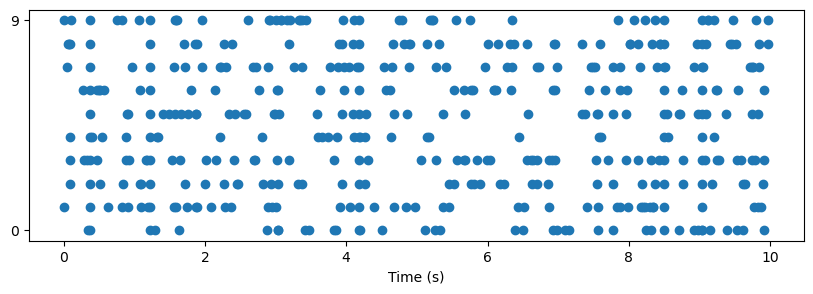

In [6]:
from viziphant.rasterplot import rasterplot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,3))
rasterplot(spiketrains, axes=ax)

In [7]:
A

[0, 0.98, 0, 0, 0, 0, 0, 0, 0, 0, 0.02]

In [8]:
# rasterplot?

In [9]:
for i in range(90):
    spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
        rate=5*pq.Hz, t_stop=10*pq.s))

In [10]:
st = spiketrains[0]
st.times

array([0.3428428 , 0.36964823, 1.22303783, 1.28863725, 1.63905792,
       2.88270894, 3.03516076, 3.03817857, 3.41886987, 3.46763254,
       3.83237276, 3.85699453, 4.17892833, 4.18912792, 4.50264362,
       5.11709083, 5.25194019, 5.32478839, 6.39516735, 6.50198542,
       6.92936517, 6.98985003, 7.10209661, 7.15895706, 7.56589684,
       7.78118491, 8.24170386, 8.31116287, 8.49874386, 8.70570514,
       8.91675734, 8.97507227, 9.03423901, 9.03853449, 9.15468654,
       9.39298729, 9.52941963, 9.61571811, 9.9134528 ]) * s

In [11]:
patterns = elephant.spade.spade(
    spiketrains=spiketrains, binsize=1*pq.ms, winlen=1, min_spikes=3,
    n_surr=100, dither=5*pq.ms,
    psr_param=[0,0,0],
    output_format='patterns')['patterns']

/Users/laurentperrinet/opt/anaconda3/envs/brainhack/lib/python3.9/site-packages/elephant/spade.py:679: UserWarning: Optimized C implementation of FCA (fim.so/fim.pyd) not found in elephant/spade_src folder, or not compatible with this Python version. You are using the pure Python implementation of fast fca.
  warnings.warn(


Time for data mining: 10.685336828231812


In [ ]:
patterns

In [ ]:
viziphant.patterns.plot_patterns(spiketrains, patterns)

## scanning some parameters

the above as one function:

In [ ]:
A_sync = 0.02
shift = 1.0

def generate_and_test(A_sync=A_sync, shift=shift):
    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=10*pq.s)
    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=10*pq.s))
    patterns = elephant.spade.spade(
                                spiketrains=spiketrains, binsize=1*pq.ms, winlen=1, min_spikes=3,
                                n_surr=100,dither=5*pq.ms,
                                psr_param=[0,0,0],
                                output_format='patterns')['patterns']
    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [ ]:
for A_sync_ in np.logspace(-2, -.5, 10):
    patterns = generate_and_test(A_sync=A_sync_)
    print(patterns)


* adding a random shift to check robustness of SPADE:


In [ ]:
for shift_ in np.logspace(-1, 1, 10, base=10, endpoint=True):
    patterns = generate_and_test(shift=shift_)
    print(patterns)